## Training the Model

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
 

From this section onwards we will be looking at <b> <font color="red"> Stage 2 </font> </b>

That is training the Model. 

Please take a look at the figure below.

</div>

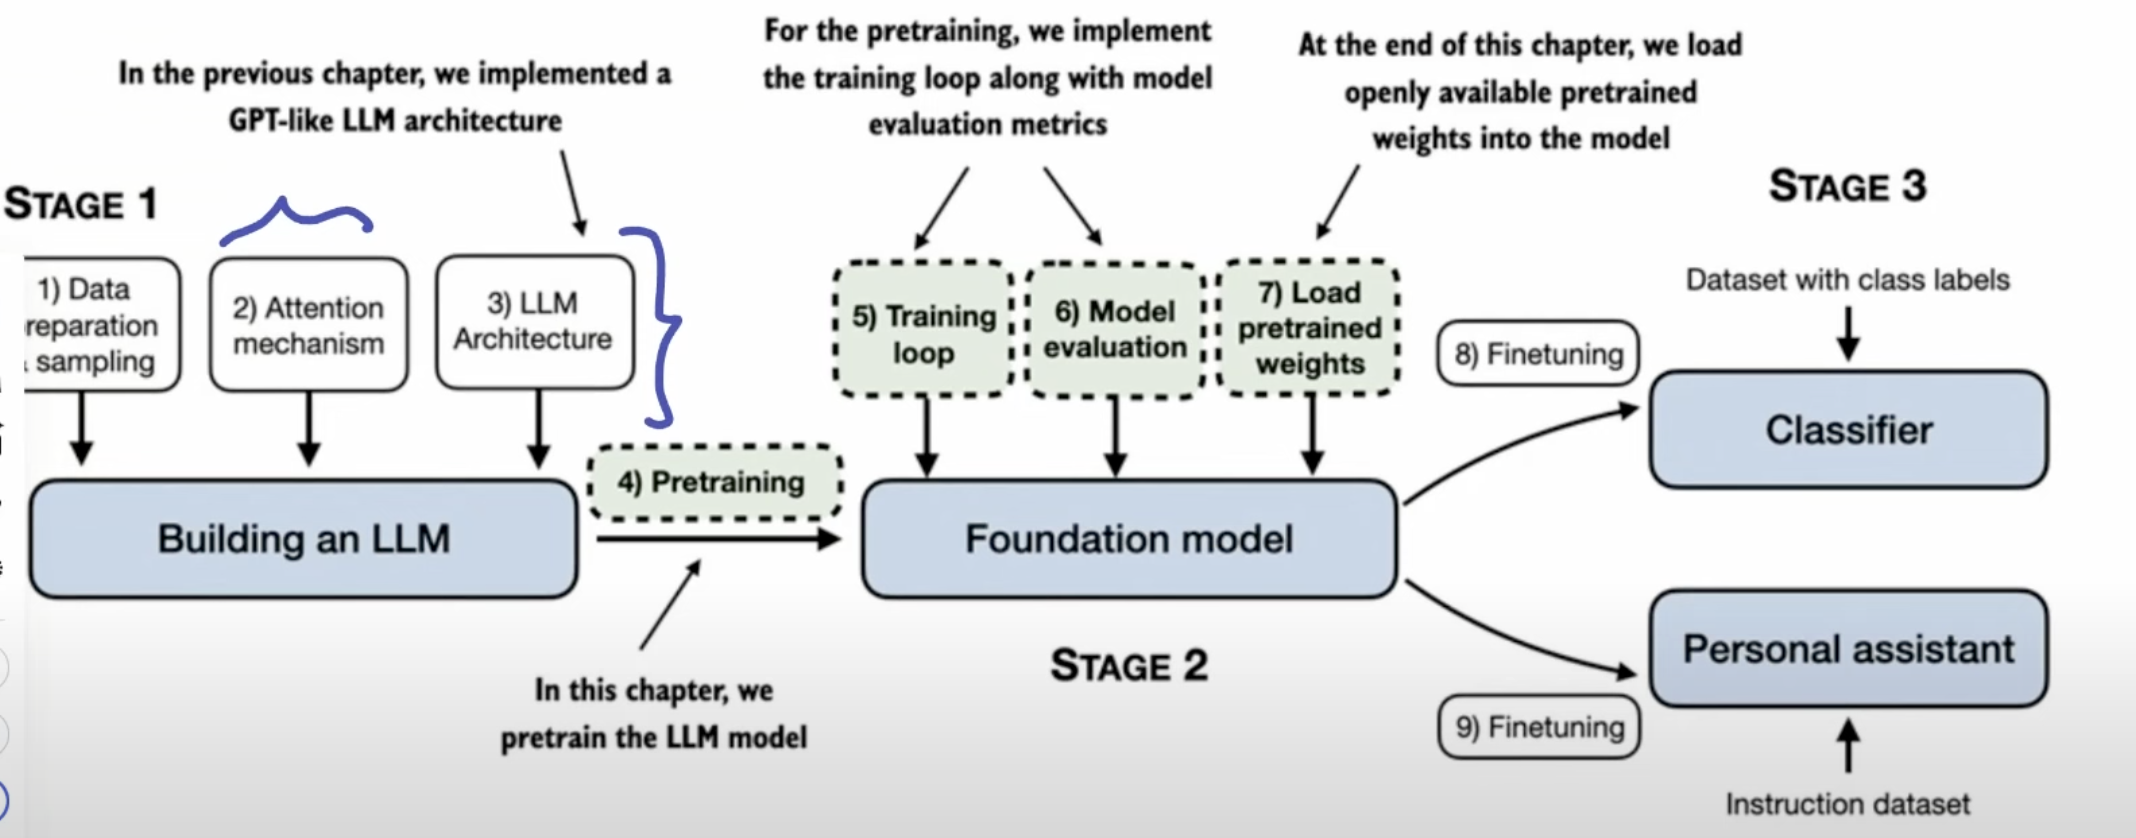

---

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
<p>
    
This Training stage consists of below Steps as shown in the figure.

We shall look at Topic/Steps 1 to 2 in this section.

    
</p>
</div>

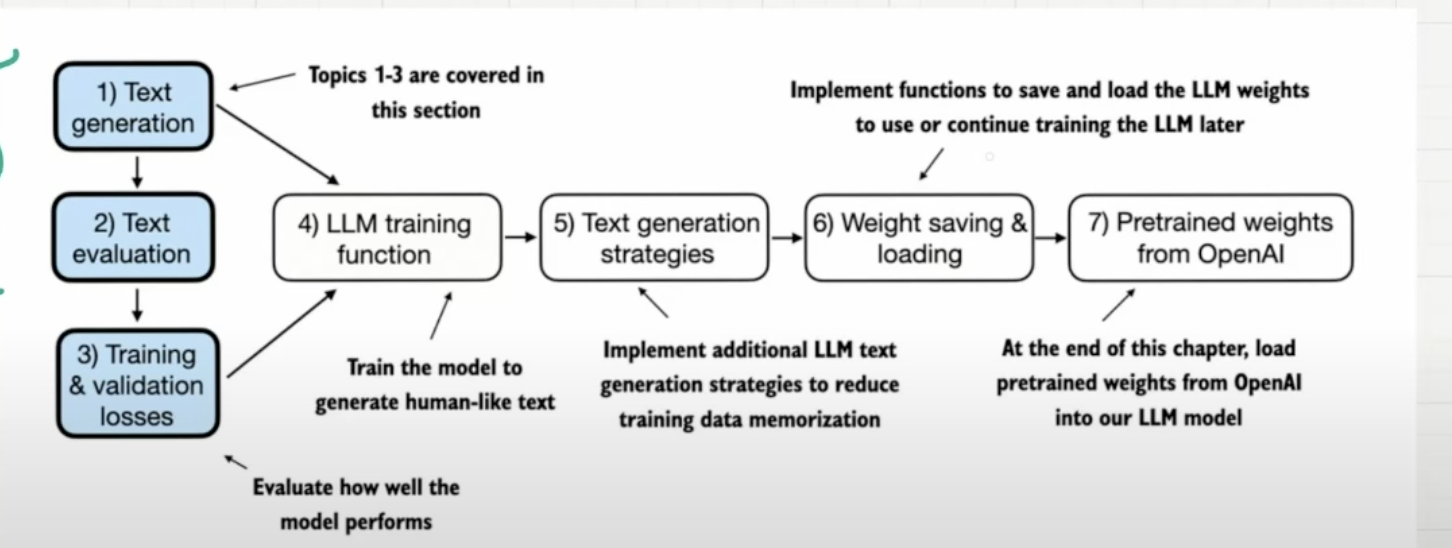

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
<p>
    
Basically like in NN , we create the datasets as Inputs and Labels for supervised learning

for ChatGPT we have already created this datasets in the formt if Input Datasets and Target Datasets.

In which we have defined Inputs as text tokens ,  and Target Datasets contains data from  next words in the input sequence

Example :-

Input = ['I' , 'Like' , 'to' , 'eat' , 'chocolate'].

Target = ['Like' , 'to' , 'eat' , 'chocolate' , 'and' , 'cold Drinks'] 

Meaning for Training LLM models , we have Input vector as our <font color="red">  Input Datasets </font>  and Target as <font color="red">  Labelled Datasets </font>

The reason being , GPT or any LLM is next word prediction alogrithm

</p>
</div>

---

## Lets start coding

### Lets put the GPT block code that was developed in previous lecture


In [12]:
import torch
import torch.nn as nn
import numpy as np

<div class="alert alert-block alert-success">
<b> Chat GPT paramters</b> 
</div>

In [13]:
# Lets define the confoguration for GPT Model
# We planning to build the GPT Model with 124M parameters. This is the small GPT version

GPT_CONFIG_124M = {
  "vocab_size"     : 50257, # BPE encoding has the vocab size of 50257
  "context_length" : 256,  # number of token we can look at ones to predict new word
  "emb_dim"        : 768,   # The Toekn Embedding dimension
  "n_heads"        : 12,    # number of attention heads
  "n_layers"       : 12,    # Number of layers (Transformer blocks)
  "drop_rate"      : 0.1,   # Dropout Rate
  "qkv_bias"       : False  # Quert-Key-Value Bias
}

<div class="alert alert-block alert-success">
<b> Multihead attention</b> 
</div>

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out ,context_length , dropout , num_heads , qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0) , f"d_out should be divisible by num_heads"

        self.d_out= d_out
        self.num_heads = num_heads
        self.head_dim= d_out // num_heads # check above for the explaination (10. Multi-head attention Part 2)
        
        # Here we have initialixed the Weight Matrices with larger dimensions already
        # This if to perform operations and then split to its respect heads based on value num_head
        # So in this example we decide d_out = 6 , hence with num_heads =2 , we will have 2 heads (causal attentions) with 3 dimension each
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        
        self.dropout= nn.Dropout(dropout)
        self.register_buffer("mask" ,
                             torch.triu(torch.ones(context_length , context_length),
                             diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape

        #print("Dimension of Weight Matrice before inputs operation" , self.W_value.weight.shape , "\n")
        # this gives us the 3 * 6 Weight matrices
        queries = self.W_key(x)
        keys    = self.W_query(x)
        values  = self.W_value(x)
        #print("Dimension of Weight Matrice after inputs operation:" , values.shape , "\n")
        #print("Values of Weight Matrice after inputs operation: \n" , values , "\n")

        # We implicitly split the matrix by adding a `num_heads` dimension
        # reshape the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        # basically we just reshaping it per token , per head  (group by tokens)
        keys = keys.reshape(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.reshape(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.reshape(b, num_tokens, self.num_heads, self.head_dim)
        
        #print("Dimension of Weight Matrice after Reshape operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Reshapr operation: \n" , values, "\n")

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # This is required becuase we want to perform multiplication operation between data (token and dimesnion)
        # so we get the data that is tokens  and embedding at rthe end
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        #print("Dimension of Weight Matrice after Grouping by Head operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Grouping by Head  operation: \n" , values, "\n")

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Now attn score dimension is (batch , head_num , tokens , head_dim)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        #print("Dimension of Attention cores Matrice :" , attn_scores.shape, "\n") 
        #print("Values of Attention cores Matrice: \n" , attn_scores, "\n")

        
        # Original mask truncated to the number of tokens and converted to boolean
        # this is tghe edge case , if there are token less then context length (end of datasets)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        #print("Values of Masked Boolean Matrix: \n" , mask_bool, "\n")

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        #print("Values of Masked Attention cores Matrice: \n" , attn_scores, "\n")

        # Perform the normalization
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Perform the droput
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        #context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-success">
<b> Layer Normalization</b> 
</div>

In [18]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))


    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1 , keepdim=True , unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var+self.eps)
        #print(norm_x)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-success">
<b> Gelu Activation Function</b> 
</div>

In [29]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        activation = 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

        return activation

<div class="alert alert-block alert-success">
<b> Feed Forward Network</b> 
</div>

In [19]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Define 1st layer with input and o/p size . Expansion
            GELU(),                                        # Define the Activation function
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # define the final layer . Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-success">
<b> Let put all this Layers to Transformer Block</b> 
</div>

<div class="alert alert-block alert-info">
<b>Keep This Block and all the Components in Mind</b> 
<p>   

We are working on build This block and stack all the components in the blocks 
   
![image.png](attachment:2e54891e-0a86-444e-a825-1507326998e7.png)



</p>
</div>

In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)  # As seen in pic , this is LayerNorm1 (from bottom)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] , This is Block 2
        x = self.drop_shortcut(x) # Then Dropout Block 3 (from bottom)
        x = x + shortcut  # Add the original input back (shortcut )

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x) 
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<div class="alert alert-block alert-info">
<b>The GPT Block</b> 
<p>   

All of the components are stacked together to complete the GPT block

</p>
</div>

In [26]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # this is the layer to convert the vector output to Logits vector 
        # of size batch * Context length * vocab_size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # Embedd the tokesn to higher dimensional space
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device)) # get Pos Embedding
        x=tok_embeds + pos_embeds # Combine the Token Embeds with its position embeds
        x=self.drop_emb(x)   # Perform Droput 
        x=self.trf_blocks(x)
        x= self.final_norm(x)
        logits = self.out_head(x)
        return logits

<div class="alert alert-block alert-info">
<b>Lets run the GPT for predicting next token </b> 
<p>   



</p>
</div>

In [30]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)

#Disable the Dropout during indeference. This sets the model to evaluation mode. 
#This is important because it disables certain features like dropout, which are only used during training to prevent overfitting. 
#In evaluation mode, the model behaves deterministically, which is essential for generating consistent and predictable outputs.
model.eval(); 

<div class="alert alert-block alert-warning">
    
We reduce the context length (context_length) to only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer
</div>

<div class="alert alert-block alert-success">
    
Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter
</div>

---


# `Next word prediction Logic`

## GENERATING TEXT FROM OUTPUT TOKENS


<div class="alert alert-block alert-success">
    
As part of generating/predicting the next token (text) in input sequence , we generate the logits which of size num_of_tokens * vocab_size.

Later we take in the last token vector , change the values of each entry (vocabs) to probablistic values.

Then select the max probablity value and append to the input sting.
Below is the Details steps of process
</div>

<div class="alert alert-block alert-info">

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

</div>

In [61]:
def generate_text_simple(model , idx , max_new_tokens , context_size):
    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        with torch.no_grad(): # This mean riun model without calculating the gradient
            logits=model(idx_cond) ### Size of Logits :- batch, n_tokens, vocab_size
        #print(logits)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :] # This means all batches , last row , all columns
        #print(logits)
        
       # Get the idx of the vocab entry with the highest probability value
        probas = torch.softmax(logits , dim=-1)
        
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [62]:
tokenizer = tiktoken.get_encoding("gpt2")

In [63]:
start_context = "Hello, I am"   # this is the input string 
encoded = tokenizer.encode(start_context)  # Tokenize using the BPE algo
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A  # Add the Batch dimenions to the matric
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [79]:
model.eval() #A  ... Disable the Droput
#model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0])) 

Output: tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 33491, 12254,
          5939,  8371, 33191, 43071]])
Output length: 14


In [80]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

# As seen below it is all gibberish , as we have not yet trained the model.
# This will improve as we train the model which is shown below

# The size of the input sequence is 14 (4 as input + max_new_tokens=10 ) , meaning we have generated the 
# 10 new tokens

Hello, I am Laur inhab Distrinereplacefly markets subsectionGW stren


---

<div class="alert alert-block alert-info">

SOme additional help methods to encode and decode the text
    
</div>

In [77]:
import tiktoken

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text , allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids , tokenizer):
    flat = token_ids.squeeze(0) # Remove Batch Dimension
    text = tokenizer.decode(flat.tolist())
    return text

In [78]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic minion cones477243 therepo expression syll


<div class="alert alert-block alert-info">

As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

</div>

<div class="alert alert-block alert-info">
<b> Calculating the LOSS - Cross Entropy</b>

As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

There has be some mechanism to calcuate and quantify that loss is minimum for the model to be predict "good text". This is achieved by calulcating the CROSS ENTROPY LOSS. 

This Loss is calculate at each training and then training the model to minimize this LOSS value. This is called training

</div>

<div class="alert alert-block alert-info">
<b> Calculating the LOSS - Cross Entropy  :- Datasets</b>
    
While training the model we need bekow datasets

1. Input Dataset :- This is the stream of input Text , we will use to training the model
2. Target Dataset :- This is the labeled dataset (as we call in NN) that signifies the ouput the model should produce or generate

In below example we define 2 datasets input and targets

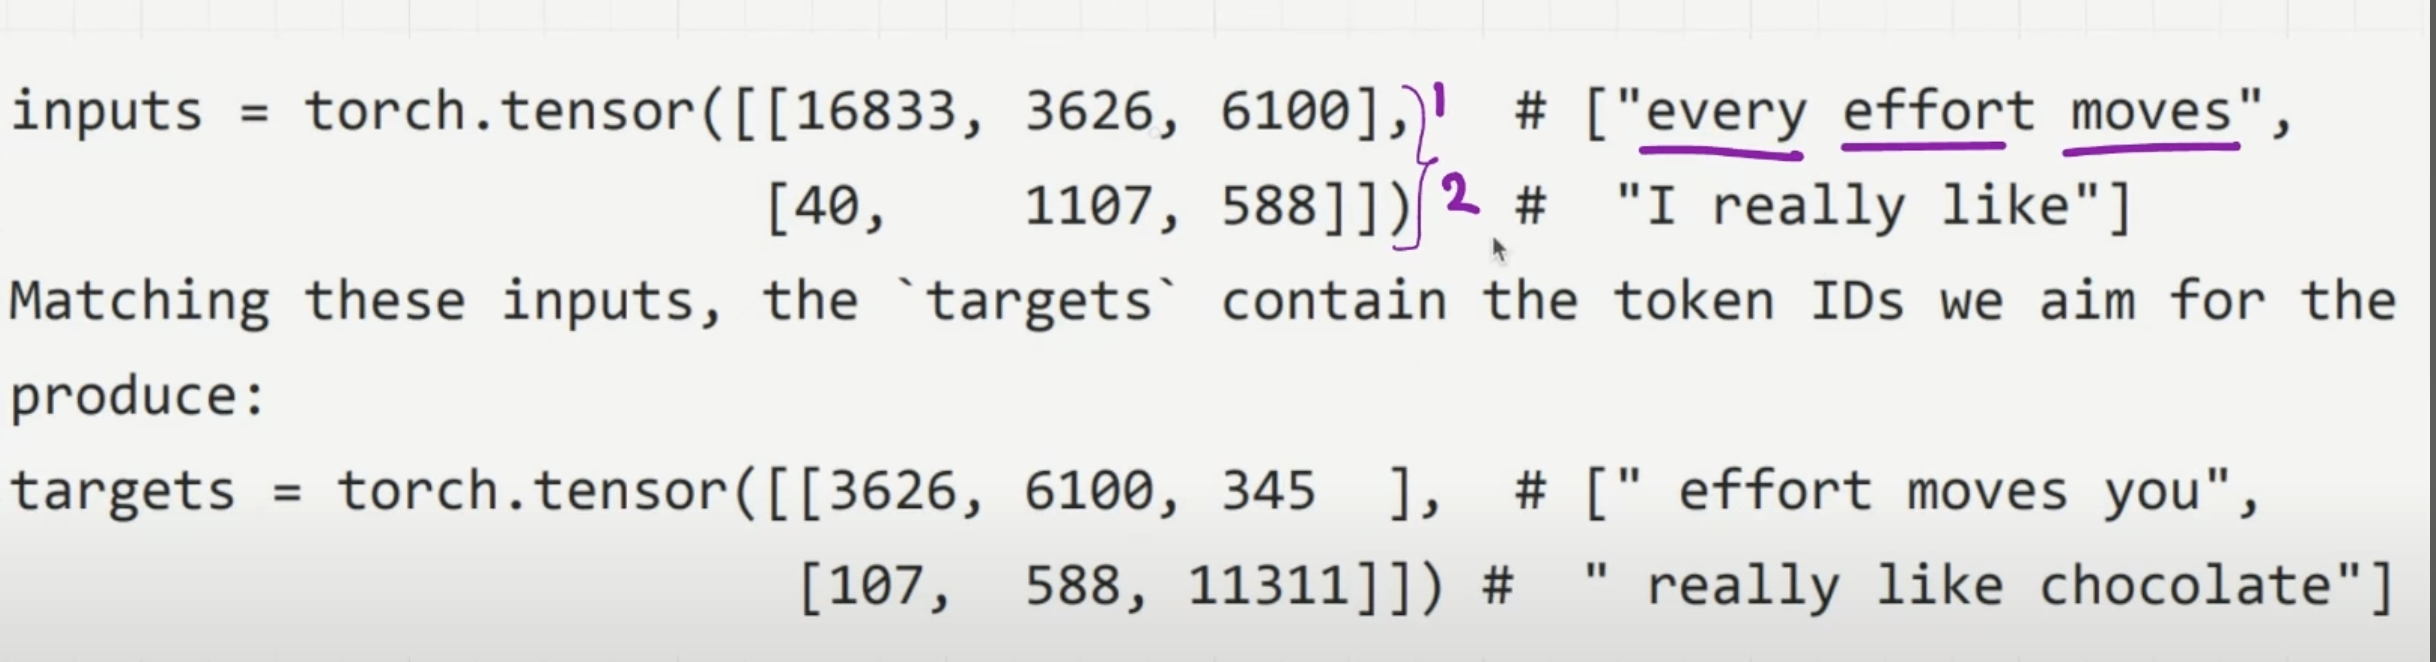

</div>

In [88]:
# inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
#                        [40,    1107, 588]])   #  "I really like"]

# targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
#                         [1107,  588, 11311]]) #  " really like chocolate"]

In [155]:
# Lets Deal with some real stuff data
# Lets create encoding for real text
# Create the Input Datasets

input_text1 = "every effort moves"  # Input Text 1
input_text2 = "I really like"        # Input Text 2

tokenizer = tiktoken.get_encoding("gpt2")

encoding_input_1 = text_to_token_ids(input_text1,tokenizer)
encoding_input_2 = text_to_token_ids(input_text2,tokenizer)

inputs=torch.cat((encoding_input_1,encoding_input_2))
print(inputs)

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])


In [156]:
# Lets Deal with some real stuff data
# Lets create encoding for real text
# Create the Target Datasets
# The Target Datasets are the inputs dataset shifted by 1 . Becuase we predict one word at a time.

ouput_text1 = " effort moves you"   # Target dataset for Input Text 1 . We shifted by one
ouput_text2 = " really like chocolate" # Target dataset for Input Text 2 . We shifted by one

tokenizer = tiktoken.get_encoding("gpt2")

encoding_output_1 = text_to_token_ids(ouput_text1,tokenizer)
encoding_output_2 = text_to_token_ids(ouput_text2,tokenizer)

targets=torch.cat((encoding_output_1,encoding_output_2))
print(targets)

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


<div class="alert alert-block alert-success">
    
Now that we have generated the Input and Target Datasets , we will be, 
Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

</div>

In [159]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)

#Disable the Dropout during indeference. This sets the model to evaluation mode. 
#This is important because it disables certain features like dropout, which are only used during training to prevent overfitting. 
#In evaluation mode, the model behaves deterministically, which is essential for generating consistent and predictable outputs.
model.eval(); 


with torch.no_grad():
    logits=model(inputs)

probas = torch.softmax(logits , dim=-1)
print(probas.shape) # The size is batches=2 (2 input sequence)  , Tokens in each batch = 3, Vocab_size=50257

torch.Size([2, 3, 50257])


<div class="alert alert-block alert-warning">
    
We have now applied the softmax for each token vector (along the columns) , so that all the values (which is of size=vocab_size) for the given token is converted into probability score.

After that as next step  , we pick or get get the token from vocabular of each token with highest probabiluty score.

Example :- 

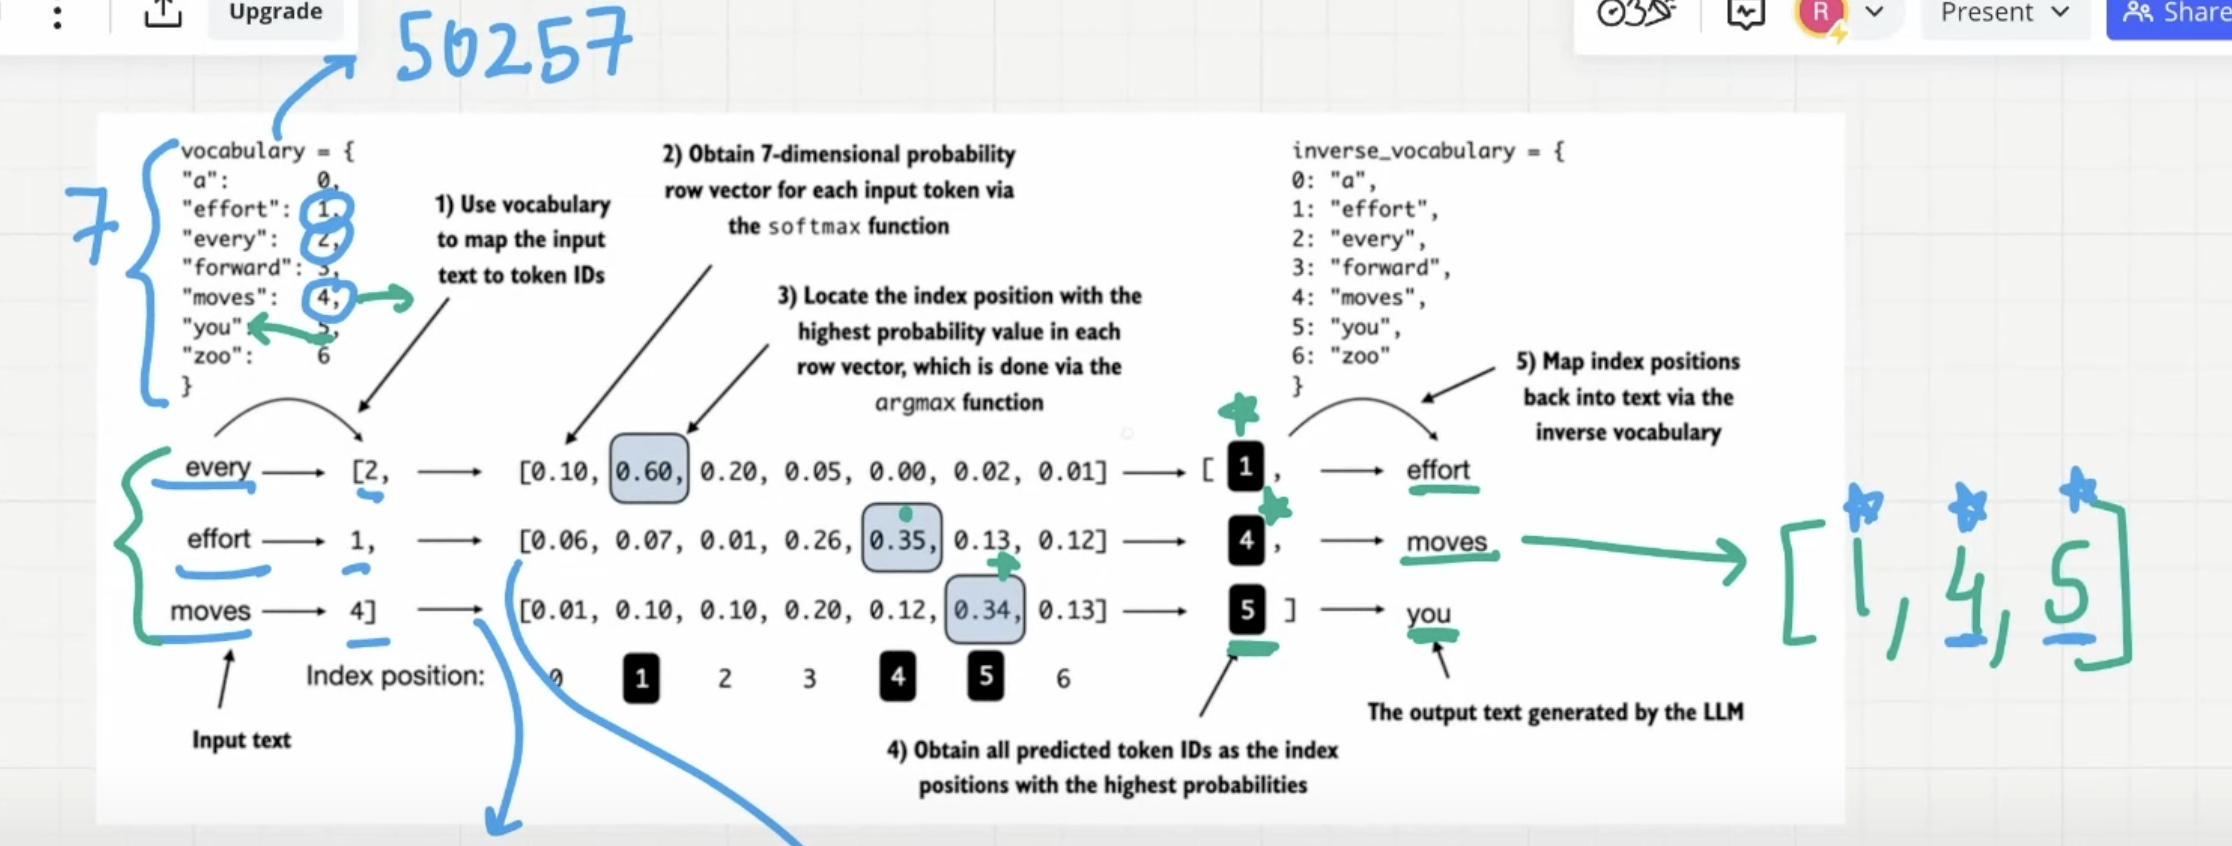

</div>

In [161]:
token_ids = torch.argmax(probas , dim=-1 ,keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [13866],
         [44376]],

        [[49906],
         [29669],
         [41751]]])


<div class="alert alert-block alert-success">
<b> Important argmax information</b>    

The ArgMax here returns the index for the elemnt with highest probability. This is calculated along the rows
</div>

<div class="alert alert-block alert-success">
<b> Look at the shape of tensor after applying the argmax</b>    

<p>
As we know the logits have the below shape (no. of Tokens * vocab_size). Please note the vocab

        [index1 , index2 , index3 ,index4 ........... index50257]
        
         
Token 1 :[vocab1 ,vocab2,vocab3,vocab4 ,.,.,.,.,.,.,.,vocab50257] -> These are the values

Token 2 :[vocab1 ,vocab2,vocab3,vocab4 ,.,.,.,.,.,.,.,vocab50257] -> These are the values

Token 3 :[vocab1 ,vocab2,vocab3,vocab4 ,.,.,.,.,.,.,.,vocab50257] -> These are the values


After applying the SoftMax , The scores/weights/values are converted to some probablistic score 

Example :-

        [index1 , index2 , index3 ,index4 ........... index50257]
         
Token 1 :[0.05, 0.1, 0.01, 0.03 ,.,.,.,.,.,.,., 0.89] ->  These are the probas values

Token 2 :[0.05, 0.1, 0.01, 0.03 ,.,.,.,.,.,.,., 0.89]  -> These are the probas values

Token 3 :[0.05, 0.1, 0.01, 0.03 ,.,.,.,.,.,.,., 0.89]  -> These are the probas values



<font color="blue"> Now what ArgMax will give after it is applied is the index value , for the element with highest probability score in the matrix along the rows. </font>

Hence we see the shape of the tensor for ArgMax function output as show above

</p>
</div>

In [163]:
token_ids.shape

torch.Size([2, 3, 1])

In [174]:
token_ids[0] # Return the values from batch 1

tensor([[16657],
        [13866],
        [44376]])

In [165]:
token_ids[1] # Return the values from batch 2

tensor([[49906],
        [29669],
        [41751]])

<div class="alert alert-block alert-success">
<b> Check how good is the predicted text</b>    
<p>
Now , we are in process calculating the Loss function. For this we need to decode both the target
and predicted text to see if they are equal to close to equal.

Below , now we will decode the token_Ids with highest probability to see what text it predicted.

Then we will see if this is equal to the target dataset value we defined
</p>

<div>

In [167]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armedbage inaction


In [175]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 2:  really like chocolate
Outputs batch 2:  pressuring empoweredfaith


<div class="alert alert-block alert-success">
<b> Check how good is the predicted text</b>    
<p>
As seen above the ouput . They are way apart . Not even close 

Look at the target ouput label we defined (First ouput string)

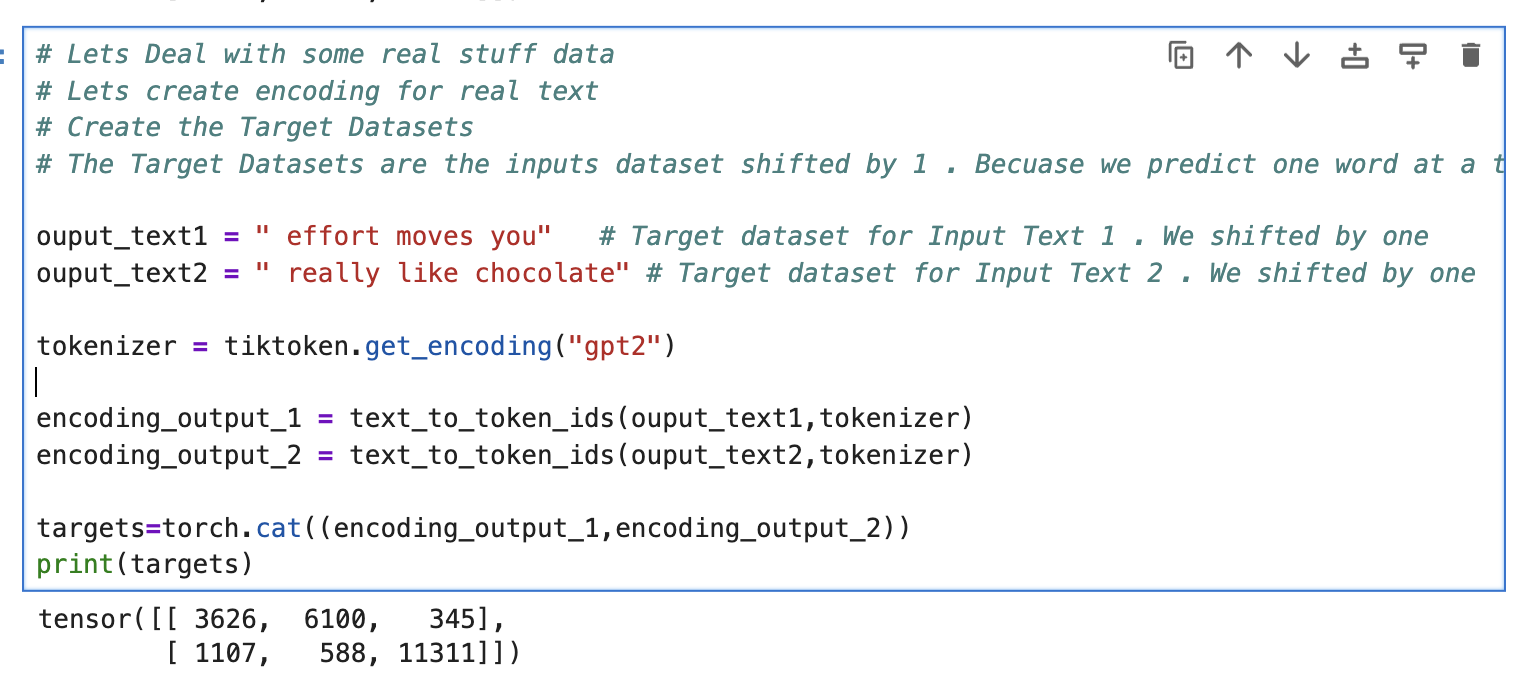
    
Also check the token_id for target and predicted , they are different

This is all without Training . We get the predicted text.
Now we will define a loss function with respect with the Target Label data and predicted text , which in turn will try to minimize the loss function but updating the weights

</p>

<div>

# Cross Entropy Loss Code

<div class="alert alert-block alert-success">

PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

</div>

In [176]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


<div class="alert alert-block alert-success">

For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:


</div>

In [178]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<div class="alert alert-block alert-info">

Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

</div>

In [179]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7875)


---

<div class="alert alert-block alert-success">

Now let us look under the hood what exactly is happening. 

We shall try to implement each step for better understanding

</div>

In [185]:
# Shape of the logits after softmax
probas.shape

torch.Size([2, 3, 50257])

In [186]:
targets[0]

tensor([3626, 6100,  345])

In [189]:
# We get the probability scores for the targets (labeled data) . These are the true values
# from the logits matrix (converted into probability using softmax) 


text_idx = 0  # This is for Batch=1

# Args :- batch_no , rows (as we have just 3 tokens)  , 
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] 
print("Text 1:", target_probas_1)  # this gives us the probability score from logits (softmax applied)  for the true data
print("Text 1 Shape:", target_probas_1.shape)

text_idx = 1 # this is for next batch=2
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)
print("Text 2 Shape:", target_probas_2.shape)

Text 1: tensor([7.4541e-05, 2.9624e-05, 1.2002e-05])
Text 1 Shape: torch.Size([3])
Text 2: tensor([1.0337e-05, 5.5172e-05, 5.1407e-06])
Text 2 Shape: torch.Size([3])


<div class="alert alert-block alert-warning">

We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

</div>

In [188]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.4269, -11.3305, -11.4798,  -9.8050, -12.1783])


<div class="alert alert-block alert-success">

Next, we compute the average log probability:
</div>

In [191]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7875)


<div class="alert alert-block alert-info">

The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

</div>

# Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

In [192]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48409.9336)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>

<div class="alert alert-block alert-info">

The perplexity is a measure of how "surprised" or "uncertain" a langauge model is when it encounters a piece of text.

Low perplexity score is good , as it is less suprised by actual text. Model is great guesser

High perplexity loss indicate model is struggling to predict text. Model is poor guesser

The perplexity score=48409 indicate that model is as uncertain about the next word as if it is randomly choosing from alost all the words in its vocabulary

</div>